In [2]:
import numpy as np
import pandas as pd
import sympy as sym
from sympy import symbols, simplify, trigsimp, expand
from matplotlib import pyplot as plt

In [55]:
H, Htet, Hphi = symbols("H theta_H phi_H")
Ms, Mtet, Mphi = symbols("Ms theta_M phi_M")
A, Ku2, g = symbols("A K_u2 gamma")
Hk1, Hk2 = symbols("H_k1 H_k2")


E = -Ms*H*(sym.sin(Htet)*sym.sin(Mtet)*sym.cos(Hphi-Mphi) + \
           sym.cos(Htet)*sym.cos(Mtet)) + \
            A*(sym.sin(Mtet)**2) + \
            Ku2*(sym.sin(Mtet)**4)

Etp = E.diff(Mtet).diff(Mphi)
Ett = E.diff(Mtet).diff(Mtet)
Epp = E.diff(Mphi).diff(Mphi)

f2 = (1/(Ms*sym.sin(Mtet)))**2 * (Ett*Epp - Etp**2)

#subs for PMA
f2 = f2.subs({Hphi: 0, Mphi: 0})
f2 = f2.subs({Ku2: Ms*Hk2/4})
f2 = f2.subs({A: Ms*(Hk1-Hk2)/2})
f2 = f2.subs({Hk2: 0})
#subs for in-plane
#f2 = f2.subs({Htet: sym.pi/2, Mtet: sym.pi/2})


f2 = sym.simplify(f2)
display(f2)


H*(H*cos(theta_H - theta_M) - 2*H_k1*sin(theta_M)**2 + H_k1)*sin(theta_H)/sin(theta_M)

In [61]:
display(Ett)
display(Epp)
display(Etp)


-2*A*sin(theta_M)**2 + 2*A*cos(theta_M)**2 - H*Ms*(-sin(theta_H)*sin(theta_M)*cos(phi_H - phi_M) - cos(theta_H)*cos(theta_M)) - 4*K_u2*sin(theta_M)**4 + 12*K_u2*sin(theta_M)**2*cos(theta_M)**2

H*Ms*sin(theta_H)*sin(theta_M)*cos(phi_H - phi_M)

-H*Ms*sin(theta_H)*sin(phi_H - phi_M)*cos(theta_M)

In [71]:
display(simplify(Epp*Ett).subs({Hphi: 0, Mphi: 0}))

H*Ms*(-4*A*sin(theta_M)**2 + 2*A + H*Ms*sin(theta_H)*sin(theta_M) + H*Ms*cos(theta_H)*cos(theta_M) - 16*K_u2*sin(theta_M)**4 + 12*K_u2*sin(theta_M)**2)*sin(theta_H)*sin(theta_M)

In [75]:
tmp = E.diff(Mtet).simplify()

tmp = tmp.subs({Hphi: 0, Mphi: 0})
tmp = tmp.subs({Ku2: Ms*Hk2/4})
tmp = tmp.subs({A: Ms*(Hk1-Hk2)/2})
tmp = tmp.subs({Hk2: 0})

display(sym.expand_trig(simplify(tmp/Ms)))

-H*(sin(theta_H)*cos(theta_M) - sin(theta_M)*cos(theta_H)) + H_k1*sin(theta_M)*cos(theta_M)

In [74]:
tmp = E.diff(Mphi).simplify()/Ms
tmp = tmp.subs({Hphi: 0, Mphi: 0})
display(tmp)

0

In [50]:
H1 = H*sym.cos(Mtet-Htet) + Hk1*(sym.cos(Mtet)**2) - Hk2*(sym.cos(Mtet)**4)
H2 = H*sym.cos(Mtet-Htet) + Hk2*(sym.cos(2*Mtet)) - sym.Rational(1,2)*Hk2*(sym.cos(2*Mtet) + sym.cos(4*Mtet))
#display(H1)
#display(H2)


f22 = sym.expand_trig((H1*H2).expand())
display(f22)

H**2*(sin(theta_H)*sin(theta_M) + cos(theta_H)*cos(theta_M))**2 + H*H_k1*(sin(theta_H)*sin(theta_M) + cos(theta_H)*cos(theta_M))*cos(theta_M)**2 + H*H_k2*(sin(theta_H)*sin(theta_M) + cos(theta_H)*cos(theta_M))*(2*cos(theta_M)**2 - 1)/2 - H*H_k2*(sin(theta_H)*sin(theta_M) + cos(theta_H)*cos(theta_M))*(8*cos(theta_M)**4 - 8*cos(theta_M)**2 + 1)/2 - H*H_k2*(sin(theta_H)*sin(theta_M) + cos(theta_H)*cos(theta_M))*cos(theta_M)**4 + H_k1*H_k2*(2*cos(theta_M)**2 - 1)*cos(theta_M)**2/2 - H_k1*H_k2*(8*cos(theta_M)**4 - 8*cos(theta_M)**2 + 1)*cos(theta_M)**2/2 - H_k2**2*(2*cos(theta_M)**2 - 1)*cos(theta_M)**4/2 + H_k2**2*(8*cos(theta_M)**4 - 8*cos(theta_M)**2 + 1)*cos(theta_M)**4/2

In [52]:
E.diff()

-H**2*(sin(theta_H)*sin(theta_M) + cos(theta_H)*cos(theta_M))**2 + H**2*sin(theta_H)**2 + H**2*sin(theta_H)*cos(theta_H)*cos(theta_M)/sin(theta_M) - H*H_k1*(sin(theta_H)*sin(theta_M) + cos(theta_H)*cos(theta_M))*cos(theta_M)**2 - H*H_k1*sin(theta_H)*sin(theta_M) + H*H_k1*sin(theta_H)*cos(theta_M)**2/sin(theta_M) - H*H_k2*(sin(theta_H)*sin(theta_M) + cos(theta_H)*cos(theta_M))*(2*cos(theta_M)**2 - 1)/2 + H*H_k2*(sin(theta_H)*sin(theta_M) + cos(theta_H)*cos(theta_M))*(8*cos(theta_M)**4 - 8*cos(theta_M)**2 + 1)/2 + H*H_k2*(sin(theta_H)*sin(theta_M) + cos(theta_H)*cos(theta_M))*cos(theta_M)**4 - H*H_k2*sin(theta_H)*sin(theta_M)**3 + 3*H*H_k2*sin(theta_H)*sin(theta_M)*cos(theta_M)**2 + H*H_k2*sin(theta_H)*sin(theta_M) - H*H_k2*sin(theta_H)*cos(theta_M)**2/sin(theta_M) - H_k1*H_k2*(2*cos(theta_M)**2 - 1)*cos(theta_M)**2/2 + H_k1*H_k2*(8*cos(theta_M)**4 - 8*cos(theta_M)**2 + 1)*cos(theta_M)**2/2 + H_k2**2*(2*cos(theta_M)**2 - 1)*cos(theta_M)**4/2 - H_k2**2*(8*cos(theta_M)**4 - 8*cos(theta_M)*

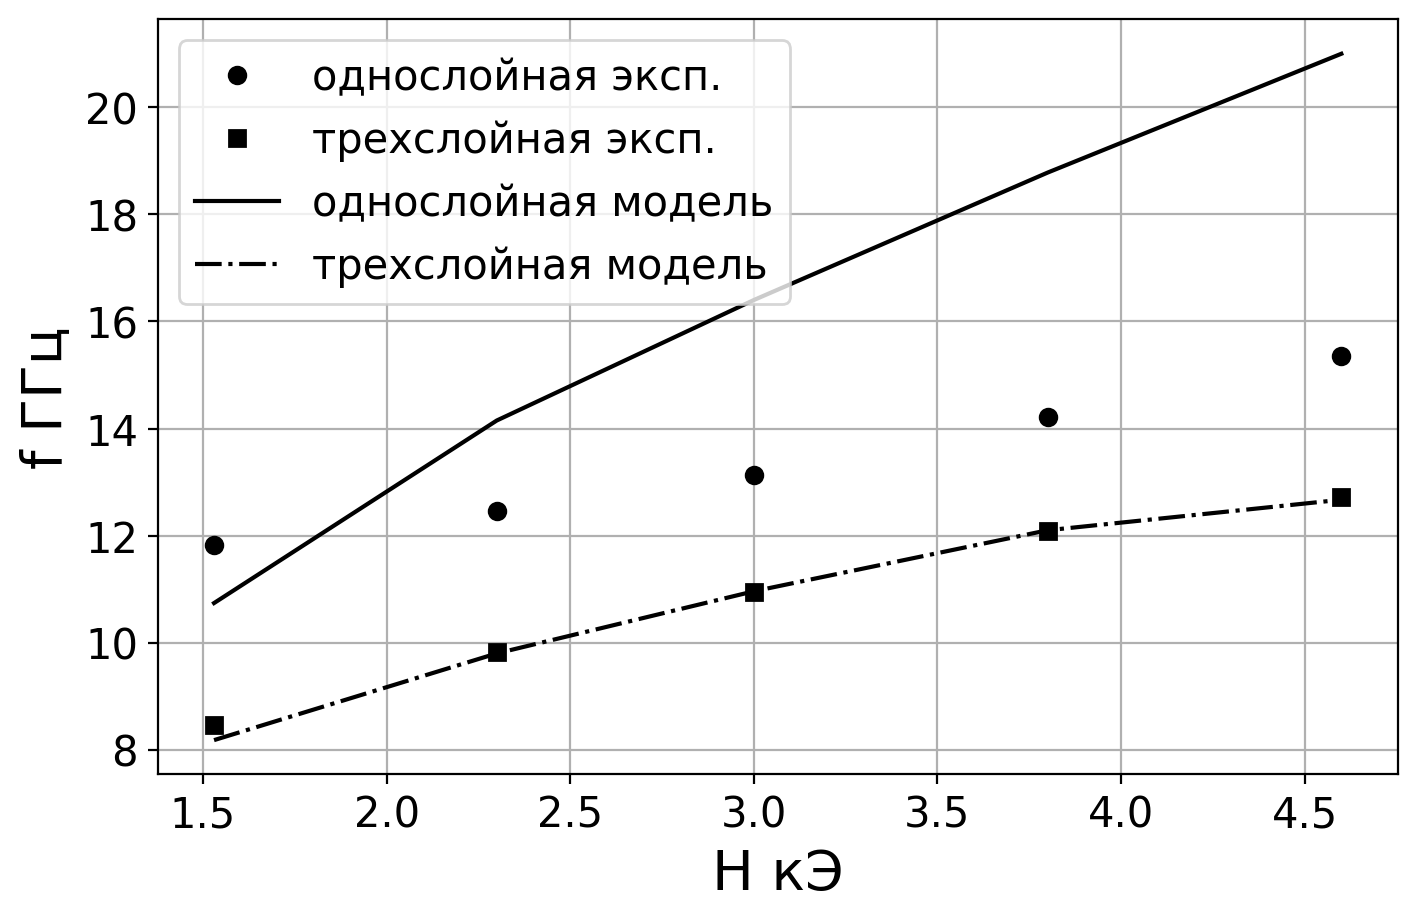

In [3]:
x = np.array([
    1.53,
    2.3,
    3,
    3.8,
    4.6
])

f1_exp = np.array([
    11.82,
    12.46,
    13.13,
    14.22,
    15.36
])

f2_exp = np.array([
    8.46,
    9.83,
    10.95,
    12.09,
    12.72
])

f1_theor = np.array([
    10.74,
    14.15,
    16.4,
    18.78,
    21
])

f2_theor = np.array([
    8.18,
    9.8,
    10.96,
    12.1,
    12.67
])


plt.figure(figsize=(8,5), dpi=200)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("H кЭ", fontsize=20)
plt.ylabel("f ГГц", fontsize=20)


plt.plot(x, f1_exp, 'ko', label='однослойная эксп.');
plt.plot(x, f2_exp, 'ks', label='трехслойная эксп.');

plt.plot(x, f1_theor, 'k-', label='однослойная модель');
plt.plot(x, f2_theor, 'k-.', label='трехслойная модель');

plt.legend(fontsize = 15)
plt.grid(True)